# Clasificación de clientes para predicción de abandono en cuentas bancarias

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)
* [2. Preparación para el modelo](#data_prep)
    * [2.1. Estudio del balance de clases](#data_balance)
    * [2.2. Selección de caracteristicas y objetivo](#char_select)
    * [2.3. Escalado de características](#data_scaling)
    * [2.4. Codificación One-Hot](#ohe)
    * [2.5. Codificación ordinal](#ordinal)
    * [2.6. Datasets de entrenamiento, validación y pruebas](#data_segment)
* [3. Modelo desbalanceado](#desbalanced)
    * [3.1. Modelo de bosque aleatorio de decisión](#model_random_forest_d)
    * [3.2. Modelo de regresión logística](#model_logistic_regression_d)
* [4. Balanceo de clases objetivo](#balancing)
    * [4.1. Regresión logística](#model_logistic_regression_bal)
    * [4.2. Bosque aleatorio de decisiones](#model_random_forest_bal)
* [5. Selección y evaluación del modelo](#model_results)
* [6. Predicciones en conjunto de pruebas](#predictions)
* [Conclusiones](#end)

## Introducción <a id="intro"></a>

Los clientes de Beta Bank están abandonando sus servicios, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos. Necesitamos predecir si un cliente dejará el banco pronto. Se tienen los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco. El objetivo es crear un modelo con el máximo valor F1 posible, en donde al menos tenga un valor de 0.59.

### Descripción de los datos

__Características__

- RowNumber: índice de cadena de datos.
- CustomerId: identificador de cliente único.
- Surname: apellido.
- CreditScore: valor de crédito.
- Geography: país de residencia.
- Gender: sexo.
- Age: edad.
- Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años).
- Balance: saldo de la cuenta.
- NumOfProducts: número de productos bancarios utilizados por el cliente.
- HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no).
- IsActiveMember: actividad del cliente (1 - sí; 0 - no).
- EstimatedSalary: salario estimado.

__Objetivo__

Exited: El cliente se ha ido (1 - sí; 0 - no)

## 1. Descripción y preparación de los datos. <a id="data_review"></a>

In [1]:
# Se importan  las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
# Importamos los datos del csv.
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [16]:
# Examinamos la información de las columnas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


El tipo de datos es correcto para casi todas las columnas; sin embargo, una de las columnas tiene datos ausentes (Tenure) y también el tipo de dato podría ser entero, ya que no usa información decimal realmente. Analizaremos el contenido y los valores ausentes de esta columna más adelante.

In [17]:
# Descubriendo las estadisticas descriptivas de los valores numericos.
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Las columnas no presentan datos anómalos o incoherentes. En el caso de la columna CustomerId que podría manejarse mejor como una columna con datos de tipo string, la mantendremos sin cambios, ya que para nuestro modelo no será incluida como una característica al no aportar información relevante para el modelo.

In [18]:
# Descubriendo las estadisticas descriptivas de los valores categoricos.
data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Para los datos categóricos observamos que la columna género se encuentra bien balanceada como característica.

En cuanto a la columna Tenure, exploraremos un poco más para conocer la razón de los valores ausentes y el tipo que lleva esta columna.

In [19]:
# Valores unicos de la columna.
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Podemos concluir que existen valores enteros del 0 al 10, por lo que un cambio al tipo int puede ser una buena práctica para esta columna.

In [20]:
# Exploración de las filas con valores ausentes.
data[data['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


A primera vista no hay ningún patrón observable para los valores ausentes de esta columna, existe una probabilidad que estos valores ausentes correspondan a valores mayores a 10, los cuales se manejaron como una categoría, pero desde que no tenemos más información de estos datos, debemos tomar una decisión para poder entrenar nuestro modelo. Al no poder imputar estos datos como 0 o como un valor específico (media o mediana), ya que podría alterar los resultados reales de nuestro modelo, optamos por descartar estas filas para nuestro entrenamiento.

In [21]:
# Descartamos los valores ausentes.
data.dropna(inplace=True)

# Comprobamos si hay valores ausentes.
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Sin valores ausentes, ahora podemos transformar el tipo de dato a entero.

In [22]:
# Convertir los datos a entero.
data['Tenure'] = data['Tenure'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   int64  
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.0+ MB


In [23]:
# Valores unicos de la columna.
data['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

Ahora que la columna no tiene valores ausentes y es de tipo entero, tenemos listos los datos de nuestras características y objetivos para los entrenamientos de modelos.

## 2. Preparación para el modelo. <a id="data_prep"></a>

Para trabajar en este proyecto utilizaremos dos tipos de modelos para hacer nuestro estudio, y elegiremos aquel que muestre mejores métricas en los resultados. Los modelos que usaremos serán un bosque aleatorio de decisiones y una regresión logística.

### 2.1. Estudio del balance de clases. <a id="data_balance"></a>

Analicemos un momento al balance de nuestra clase objetivo.

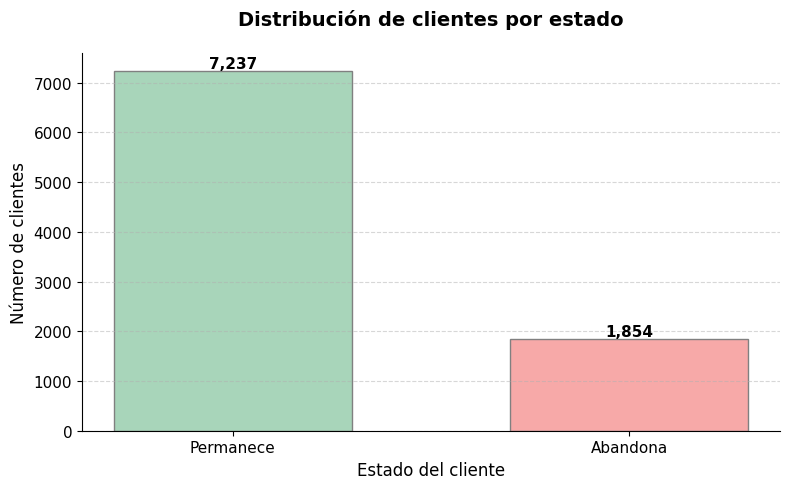

In [35]:
# Visualización de la distribución de clientes por estado (Permanece/Abandono).
counts = data['Exited'].value_counts().sort_index().values 
labels = ['Permanece', 'Abandona']

# Figura y estilo
plt.figure(figsize=(8, 5))
pastel_colors = ['#A8D5BA', '#F7A9A8'] 
bars = plt.bar(labels, counts, color=pastel_colors, width=0.6, edgecolor='gray', linewidth=1)

# Títulos y etiquetas
plt.title('Distribución de clientes por estado', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Número de clientes', fontsize=12)
plt.xlabel('Estado del cliente', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetas sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Remover bordes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Es evidente un desbalance en la clase objetivo ya que por cada cliente que abandona hay 3,9 clientes que permanecen. Para iniciar exploraremos algunos modelos sin prestar atención a este desbalance y posteriormente lo corregiremos y reevaluaremos nuestros modelos.

### 2.2. Selección de caracteristicas y objetivo. <a id="char_select"></a>

En este caso seleccionaremos solo las características relevantes para nuestro modelo. De todas las características descartaremos únicamente 3, de las cuales no aportar información útil para identificar si un usuario se va o se queda. Estas son RowNumber, CustomerId y Surname. Tampoco tendremos en cuenta la columna Exited, ya que esta es nuestra columna objetivo.

In [12]:
# Seleccionando las columnas de las caracteristicas.
data_features = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis = 1)
data_features

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9994,800,France,Female,29,2,0.00,2,0,0,167773.55
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58


In [13]:
# Seleccionando la columna objetivo.
data_target = data['Exited']
data_target

0       1
1       0
2       1
3       0
4       0
       ..
9994    0
9995    0
9996    0
9997    1
9998    1
Name: Exited, Length: 9091, dtype: int64

### 2.3. Escalado de características. <a id="data_scaling"></a>

Manejaremos los datos numéricos estandarizados, ya que muchos de ellos presentan magnitudes diferentes. Las columnas que estandarizaremos serán: CreditScore, Age, Tenure, Balance, NumOfProducts y EstimatedSalary.

In [14]:
# Filtrando las columnas a estandarizar.
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#Estandarización.
scaler = StandardScaler()
scaler.fit(data_features[numeric])

data_features[numeric] = scaler.transform(data_features[numeric])
data_features

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.329200,France,Female,0.289040,-1.035627,-1.227780,-0.912601,1,1,0.020264
1,-0.443301,Spain,Female,0.194298,-1.381103,0.116887,-0.912601,0,1,0.214527
2,-1.542828,France,Female,0.289040,1.037224,1.333920,2.529911,1,0,0.238632
3,0.500631,France,Female,0.004815,-1.381103,-1.227780,0.808655,0,0,-0.110281
4,2.066937,Spain,Female,0.383782,-1.035627,0.785996,-0.912601,1,1,-0.366132
...,...,...,...,...,...,...,...,...,...,...
9994,1.548293,France,Female,-0.942603,-1.035627,-1.227780,0.808655,0,0,1.173038
9995,1.247479,France,Male,0.004815,0.000798,-1.227780,0.808655,1,0,-0.067866
9996,-1.397607,France,Male,-0.374153,1.728174,-0.307305,-0.912601,1,1,0.026354
9997,0.604360,France,Female,-0.279411,0.691748,-1.227780,-0.912601,0,1,-1.008227


### 2.4. Codificación One-Hot. <a id="ohe"></a>

Para realizar el modelo de regresión logística requeriremos que algunas características se encuentren en codificación OHE para mejorar sus resultados. Generaremos esta codificación para las clases Geography y Gender.

In [15]:
# Contruyendo las columnas OHE
ohe = pd.get_dummies(data_features[['Geography', 'Gender']])
ohe

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,0,0,1,0
1,0,0,1,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,0,0,1,1,0
...,...,...,...,...,...
9994,1,0,0,1,0
9995,1,0,0,0,1
9996,1,0,0,0,1
9997,1,0,0,1,0


In [16]:
# Cambiando las columnas a las codificadas.
data_features_ohe = data_features.drop(['Geography', 'Gender'], axis=1)

data_features_ohe = pd.concat([data_features_ohe, ohe], axis=1)
data_features_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.329200,0.289040,-1.035627,-1.227780,-0.912601,1,1,0.020264,1,0,0,1,0
1,-0.443301,0.194298,-1.381103,0.116887,-0.912601,0,1,0.214527,0,0,1,1,0
2,-1.542828,0.289040,1.037224,1.333920,2.529911,1,0,0.238632,1,0,0,1,0
3,0.500631,0.004815,-1.381103,-1.227780,0.808655,0,0,-0.110281,1,0,0,1,0
4,2.066937,0.383782,-1.035627,0.785996,-0.912601,1,1,-0.366132,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1.548293,-0.942603,-1.035627,-1.227780,0.808655,0,0,1.173038,1,0,0,1,0
9995,1.247479,0.004815,0.000798,-1.227780,0.808655,1,0,-0.067866,1,0,0,0,1
9996,-1.397607,-0.374153,1.728174,-0.307305,-0.912601,1,1,0.026354,1,0,0,0,1
9997,0.604360,-0.279411,0.691748,-1.227780,-0.912601,0,1,-1.008227,1,0,0,1,0


Ahora contamos con las clases codificadas y escaladas listas para introducirse en un modelo de regresión logística.

### 2.5. Codificación ordinal. <a id="ordinal"></a>

Ya que otro de los tipos de modelo que probaremos será un bosque aleatorio de decisión, la codificación OHE no será la más indicada para este tipo de modelo, en este caso codificaremos las mismas clases Geography y Gender usando la codificación ordinal.

In [17]:
# Seleccionando las clases categoricas.
categorical = ['Geography', 'Gender']
data_features_ordinal = data_features.copy()

# Codificación Ordinal.
encoder = OrdinalEncoder()

data_features_ordinal[categorical] = encoder.fit_transform(data_features[categorical])
data_features_ordinal

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.329200,0.0,0.0,0.289040,-1.035627,-1.227780,-0.912601,1,1,0.020264
1,-0.443301,2.0,0.0,0.194298,-1.381103,0.116887,-0.912601,0,1,0.214527
2,-1.542828,0.0,0.0,0.289040,1.037224,1.333920,2.529911,1,0,0.238632
3,0.500631,0.0,0.0,0.004815,-1.381103,-1.227780,0.808655,0,0,-0.110281
4,2.066937,2.0,0.0,0.383782,-1.035627,0.785996,-0.912601,1,1,-0.366132
...,...,...,...,...,...,...,...,...,...,...
9994,1.548293,0.0,0.0,-0.942603,-1.035627,-1.227780,0.808655,0,0,1.173038
9995,1.247479,0.0,1.0,0.004815,0.000798,-1.227780,0.808655,1,0,-0.067866
9996,-1.397607,0.0,1.0,-0.374153,1.728174,-0.307305,-0.912601,1,1,0.026354
9997,0.604360,0.0,0.0,-0.279411,0.691748,-1.227780,-0.912601,0,1,-1.008227


Estas clases están listas para usarse en el entrenamiento del modelo de bosque aleatorio.

### 2.6. Datasets de entrenamiento, validación y pruebas. <a id="data_segment"></a>

Dividiremos los datos de las características y los objetivos en 3 grupos para cada conjunto preparado (regresión logística y bosque de decisiones). Los 3 grupos corresponderán a un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas.

In [18]:
# Datasets para regresión logistica.
# Generando dataset de entrenamiento con el 60% de los datos.
data_features_ohe_training, data_features_ohe_valid, data_target_ohe_training, data_target_ohe_valid = train_test_split(data_features_ohe, data_target, test_size=0.4, random_state=12345)

# Generando dataset de validación y prueba con el 20% y 20% de los datos.
data_features_ohe_valid, data_features_ohe_test, data_target_ohe_valid, data_target_ohe_test = train_test_split(data_features_ohe_valid, data_target_ohe_valid, test_size=0.5, random_state=12345)

In [19]:
# Datasets para bosque aleatorio.
# Generando dataset de entrenamiento con el 60% de los datos.
data_features_ordinal_training, data_features_ordinal_valid, data_target_ordinal_training, data_target_ordinal_valid = train_test_split(data_features_ordinal, data_target, test_size=0.4, random_state=12345)

# Generando dataset de validación y prueba con el 20% y 20% de los datos.
data_features_ordinal_valid, data_features_ordinal_test, data_target_ordinal_valid, data_target_ordinal_test = train_test_split(data_features_ordinal_valid, data_target_ordinal_valid, test_size=0.5, random_state=12345)

## 3. Modelo desbalanceado. <a id="desbalanced"></a>

### 3.1. Modelo de bosque aleatorio de decisión. <a id="model_random_forest_d"></a>

Realizaremos un estudio para determinar los hiperparámetros más apropiados con base en la métrica F1. También utilizaremos el conjunto de datos que codificamos ordinalmente.

In [20]:
# Declarar variables para almacenar los resultados.
best_score = 0
best_estimators = 0
best_depth = 0

# Iterar en diferentes opciones de hiperparametros para el bosque.
for estimators in range(10, 60, 10):
    for depth in range(1, 11):
        # Crear la instancia del bosque aleatorio y entrenarlo.
        model_rfc = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=12345)
        model_rfc.fit(data_features_ordinal_training, data_target_ordinal_training)
        
        # Predicción para el modelo de validación.
        data_predict_ordinal_valid = model_rfc.predict(data_features_ordinal_valid)
        
        # Evaluación del modelo.
        score = f1_score(data_target_ordinal_valid, data_predict_ordinal_valid)
        
        # Comparación del modelo con los otros.
        if score > best_score:
            best_score = score
            best_estimators = estimators
            best_depth = depth

# Imprimir los resultados            
print(f'El mejor valor f1 es {best_score} en el bosque con {best_estimators} estimadores y de profundidad {best_depth}.')

El mejor valor f1 es 0.5830508474576271 en el bosque con 30 estimadores y de profundidad 10.


El bosque aleatorio de decisiones con el mejor resultado de la métrica F1 es aquel con 30 estimadores y de profundidad 10, este nos proporcionó un valor de 0.58, un valor que no satisface nuestro límite propuesto de 0.59, continuaremos explorando el modelo de regresión logística y también evaluando este mismo modelo con las clases balanceadas.

### 3.2. Modelo de regresión logística. <a id="model_logistic_regression_d"></a>

Para este modelo usaremos el conjunto de datos codificados con One-Hot.

In [21]:
# Crear una instancia del modelo y entrenarlo.
model_rl = LogisticRegression(solver='liblinear', random_state=12345)
model_rl.fit(data_features_ohe_training, data_target_ohe_training)

# Predicción para el conjunto de validación.
data_predict_ohe_valid = model_rl.predict(data_features_ohe_valid)

# Evaluación del modelo con la metric f1.
model_rl_score = f1_score(data_target_ohe_valid, data_predict_ohe_valid)

print(f'El modelo de regresión lineal tiene un valor f1 de {model_rl_score}')

El modelo de regresión lineal tiene un valor f1 de 0.3033932135728543


Este modelo tiene un valor f1 de 0.3, un valor mucho menor que el primer modelo, aunque cabe recordar que aquí nuestras clases se encuentran fuertemente desbalanceadas, por lo que aún podemos mejorar este valor al hacernos cargo de ellas.

Como conclusión, ninguno de los dos modelos aquí estudiados podría satisfacer las necesidades del proyecto sin un balanceo de clases. Es por eso que esta característica de los datos debe ser tomada en cuenta y darle relevancia cuando tiene un sesgo de desbalance fuerte.

## 4. Balanceo de clases objetivo. <a id="balancing"></a>

Realizaremos balanceos de la clase objetivo, para ello utilizaremos diferentes métodos dependiendo del modelo utilizado.

__Regresión logística__
- Ajuste de peso de clase.
- Ajuste del umbral de clasificación.

__Bosque aleatorio__
- Sobre muestreo.
- Ajuste del umbral de clasificación.

### 4.1. Regresión logística. <a id="model_logistic_regression_bal"></a>

Para balancear el modelo, especificaremos en el hiperparámetro class_weight que queremos las clases balanceadas. 

In [22]:
# Crear una instancia del modelo y entrenarlo con el ajuste de clases.
model_rl = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)
model_rl.fit(data_features_ohe_training, data_target_ohe_training)

# Predicción para el conjunto de validación.
data_predict_ohe_valid = model_rl.predict(data_features_ohe_valid)

# Evaluación del modelo con la metric f1.
model_rl_score = f1_score(data_target_ohe_valid, data_predict_ohe_valid)

print(f'El modelo de regresión lineal tiene un valor f1 de {model_rl_score}')

El modelo de regresión lineal tiene un valor f1 de 0.509731232622799


El resultado de este balance de clases resultó en un incremento de la métrica F1; sin embargo, aún no logra satisfacer nuestro umbral de 0.59. Ahora realizaremos otro tipo de balanceo, ajustando el umbral de clasificación de este modelo.

In [23]:
# Entrenamos el modelo y predecimos las probabilidades.
model_rl = LogisticRegression(solver='liblinear', random_state=12345)
model_rl.fit(data_features_ohe_training, data_target_ohe_training)
data_probabilities_ohe_valid = model_rl.predict_proba(data_features_ohe_valid)
probabilities_one_ohe_valid = data_probabilities_ohe_valid[:, 1]

# Establecemos variables para almacenar los resultados.
best_score = 0
best_threshold = 0

# Hacemos el estudio para evaluar el mejor umbral usando la metrica f1.
for threshold in np.arange(0, 0.5, 0.01):
    predicted_valid = probabilities_one_ohe_valid > threshold
    score = f1_score(data_target_ohe_valid, predicted_valid)
    if score > best_score:
        best_score = score
        best_threshold = threshold

# Mostramos los resultados.      
print(f'El mejor resultado de f1 es {best_score} y se obtiene en el umbral {best_threshold}')

El mejor resultado de f1 es 0.508577194752775 y se obtiene en el umbral 0.23


Utilizando este método de balanceo también observamos mejoras similares en el modelo, aunque siguen mostrando un desempeño menor al deseado. Continuaremos las exploraciones en el otro modelo, el bosque aleatorio de decisiones.

### 4.2. Bosque aleatorio de decisiones. <a id="model_random_forest_bal"></a>

El primer método de balanceo consistirá en realizar un sobre muestreo de la clase extraña, es decir, '1'.

In [24]:
# Separando las filas de 0 y 1.
features_zeros = data_features_ordinal_training[data_target_ordinal_training == 0]
features_ones = data_features_ordinal_training[data_target_ordinal_training == 1]
target_zeros = data_target_ordinal_training[data_target_ordinal_training == 0]
target_ones = data_target_ordinal_training[data_target_ordinal_training == 1]

# Encontrar la proporción por la que se debe ampliar la muestra de 1.
repeat = round(len(target_zeros)/len(target_ones))

# Aumentando la proporcion de 1 y uniendolos con los 0.
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

# Mezclando las observaciones.
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
print('Conjunto de caracteristicas:\n', features_upsampled)
print('Conjunto objetivo:\n', target_upsampled)

Conjunto de caracteristicas:
       CreditScore  Geography  Gender       Age    Tenure   Balance  \
3655     1.071140        1.0     1.0 -0.374153  0.346273  0.353996   
8212    -0.495166        0.0     1.0 -0.658378  0.691748 -1.227780   
8760     0.272428        2.0     0.0 -0.468894  1.728174  1.526634   
8240     1.444564        1.0     1.0  1.046975  1.037224  0.720659   
7498    -0.215098        0.0     0.0 -0.279411  1.037224  0.803456   
...           ...        ...     ...       ...       ...       ...   
243      0.085716        1.0     1.0  2.657586  0.346273  0.656047   
3343    -1.833268        0.0     1.0 -0.184669 -0.690152  0.351516   
2855     0.614733        2.0     0.0  3.415520  0.000798 -1.227780   
9390     1.050394        1.0     0.0 -0.184669  0.000798  0.589934   
6273     0.957038        2.0     1.0  0.383782 -1.035627  1.368358   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
3655       0.808655          0               1         0.103010

Una vez hemos aumentado el muestreo de la clase '1', vamos a volver a evaluar el modelo usando los hiperparámetros que identificamos previamente para el número de estimadores y la profundidad de los árboles.

In [25]:
# Entrenamos el modelo con los nuevos conjuntos.
model_rfc = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=12345)
model_rfc.fit(features_upsampled, target_upsampled)

# Evaluamos la metrica F1.
data_predicted_ordinal_valid = model_rfc.predict(data_features_ordinal_valid)

print(f'El valor f1 es {f1_score(data_target_ordinal_valid, data_predicted_ordinal_valid)}.')

El valor f1 es 0.6181384248210023.


Utilizando este método de balanceo y este modelo, apenas logramos superar el umbral con un valor de 0.62 en la métrica F1. Este modelo se postula como nuestra primera opción para probar con el conjunto test. Ahora comprobaremos los resultados ajustando el umbral de este modelo.

In [26]:
# Entrenamos el modelo y predecimos las probabilidades.
model_rfc = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=12345)
model_rfc.fit(data_features_ordinal_training, data_target_ordinal_training)
data_probabilities_ordinal_valid = model_rfc.predict_proba(data_features_ordinal_valid)
probabilities_one_ordinal_valid = data_probabilities_ordinal_valid[:, 1]

# Establecemos variables para almacenar los resultados.
best_score = 0
best_threshold = 0

# Hacemos el estudio para evaluar el mejor umbral usando la metrica f1.
for threshold in np.arange(0, 0.5, 0.01):
    predicted_valid = probabilities_one_ordinal_valid > threshold
    score = f1_score(data_target_ordinal_valid, predicted_valid)
    if score > best_score:
        best_score = score
        best_threshold = threshold

# Mostramos los resultados.      
print(f'El mejor resultado de f1 es {best_score} y se obtiene en el umbral {best_threshold}')

El mejor resultado de f1 es 0.6333333333333333 y se obtiene en el umbral 0.36


En este método hemos logrado un valor de F1 de hasta 0.63 al usar un umbral de 0.36 para clasificar la predicción del modelo como 1, siendo el modelo con los resultados más altos en esta métrica.

## 5. Selección y evaluación del modelo. <a id="model_results"></a>

Al obtener resultados que cumplen con la condición de superar valores de 0.59 en la métrica F1, se elegirá el modelo de Bosque Aleatorio de decisiones para continuar con los estudios y se dejará de lado la regresión logística. Los hiperparámetros para nuestro bosque serán de 30 estimadores y de longitud máxima de árbol 10. También el umbral de clasificación será de 0.36.

Revisaremos algunas otras métricas para asegurarnos que el modelo de bosque aleatorio con ajuste de umbral es un buen modelo para realizar predicciones en nuestro negocio. Primero revisaremos la curva ROC y el área bajo esta curva para revisar la relación entre Verdaderos positivos y Falsos positivos y que nuestro modelo prediga mejores respuestas que respuestas aleatorias.

In [27]:
# Especificamos y entrenamos el modelo elegido.
model = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=12345)
model.fit(data_features_ordinal_training, data_target_ordinal_training)

# Prediccion de las probabilidades para  la curva ROC.
data_probabilities_ordinal_valid = model.predict_proba(data_features_ordinal_valid)
probabilities_one_ordinal_valid = data_probabilities_ordinal_valid[:, 1]

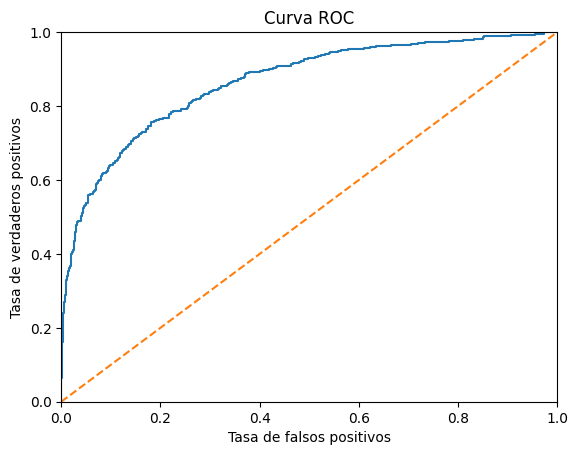

In [28]:
# Encontrando las variables de la curva ROC.
fpr, tpr, thresholds = roc_curve(data_target_ordinal_valid, probabilities_one_ordinal_valid)

# Generando la figura.
plt.figure()

plt.plot(fpr, tpr)

# Curva ROC para modelo aleatorio (parece una línea recta).
plt.plot([0, 1], [0, 1], linestyle='--')

# Ajustes para la gráfica.
plt.xlim([0,1])
plt.ylim([0,1]) 

plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")

plt.show()

In [29]:
# Calculando el área bajo la curva de la gráfica.
auc_roc = roc_auc_score(data_target_ordinal_valid, probabilities_one_ordinal_valid)
print(auc_roc)

0.8640072746416522


Acabamos de obtener un resultado bastante aceptable para nuestro modelo con valoración de F1 0.63, en este caso el resultado del área bajo la curva es de 0.86 aproximadamente, 36 puntos decimales por encima del resultado con respuestas aleatorias (0.5) lo que significa que nuestro modelo presenta mejores respuestas que este. Revisemos ahora si el modelo está sobre ajustado.

In [30]:
# Definiendo el umbral.
threshold = 0.36

# Hallando las prediciones para el conjunto de entrenamiento.
train_probabilities = model.predict_proba(data_features_ordinal_training)
probabilities_one_train = train_probabilities[:, 1]
train_predictions = probabilities_one_train > threshold
  
# Hallando las predicciones para el conjunto de validación.
valid_probabilities = model.predict_proba(data_features_ordinal_valid)
probabilities_one_valid = valid_probabilities[:, 1]
valid_predictions = probabilities_one_valid > threshold

# Calculando la exactitud para ambos conjuntos de predicciones.
print('Exactitud')
print('Conjunto de entrenamiento:', accuracy_score(data_target_ordinal_training, train_predictions))
print('Conjunto de validación:', accuracy_score(data_target_ordinal_valid, valid_predictions))

Exactitud
Conjunto de entrenamiento: 0.9218921892189219
Conjunto de validación: 0.8547854785478548


Los resultados nos muestran una diferencia en la métrica de exactitud de 0.07 puntos, esto nos indica un sobre ajuste muy ligero que despierta ninguna alarma para nuestro modelo.

## 6. Predicciones en conjunto de pruebas. <a id="predictions"></a>

Ahora que hemos comprobado que nuestro modelo es apto para realizar predicciones, lo pondremos a prueba con nuestro set destinado para ello. También utilizaremos los datos de entrenamiento y validación para volver a entrenar nuestro modelo y procurar mejorar las predicciones.

In [31]:
# Uniendo los conjuntos de entrenamiento y validación.
data_features_training = pd.concat([data_features_ordinal_training, data_features_ordinal_valid])
data_target_training = pd.concat([data_target_ordinal_training, data_target_ordinal_valid])

print(data_features_training)
print(data_target_training)

      CreditScore  Geography  Gender       Age    Tenure   Balance  \
9344     0.791072        0.0     0.0 -1.037345 -1.035627  0.553139   
3796    -1.179777        0.0     1.0 -1.226829  0.691748  0.479334   
7462    -0.422556        0.0     1.0  0.099557  1.382699 -1.227780   
1508    -0.775234        0.0     1.0 -0.279411  0.346273 -1.227780   
4478    -1.055302        0.0     1.0 -0.753120 -0.344677 -1.227780   
...           ...        ...     ...       ...       ...       ...   
7505     0.085716        2.0     1.0 -1.132087 -0.344677 -1.227780   
2232    -0.018013        2.0     1.0 -0.279411  1.037224 -1.227780   
3720    -1.843641        1.0     1.0  0.099557  1.037224  1.220251   
5196     0.708089        0.0     0.0 -1.605796  0.691748  0.607981   
2460     0.096089        1.0     1.0  0.194298 -1.381103  0.856438   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
9344      -0.912601          1               0         0.021737  
3796      -0.912601        

In [32]:
# Reentrenamos el modelo.
model = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=12345)
model.fit(data_features_training, data_target_training)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=12345)

In [33]:
# Confirmando el umbral
threshold = 0.36

# Hallando las predicciones para el conjunto de prueba.
test_probabilities = model.predict_proba(data_features_ordinal_test)
probabilities_one_test = test_probabilities[:, 1]
test_predictions = probabilities_one_test > threshold

# Encontrando el valor de F1 para el set de pruebas.
test_score = f1_score(data_target_ordinal_test, test_predictions)

# Imprimiendo resultados.
print(f'El valor f1 es {test_score}.')

El valor f1 es 0.5953488372093022.


Nos damos cuenta de que el valor de F1 para el conjunto de pruebas es de 0.59, lo suficientemente bueno para ser aprobado; sin embargo, vamos a reevaluar nuevamente los hiperparámetros y el umbral usando todos los datos nuevos de entrenamiento y el conjunto de pruebas, esto con el fin de actualizarlos mejor con los nuevos datos que han ingresado.

In [34]:
# Declarar variables para almacenar los resultados.
best_score = 0
best_estimators = 0
best_depth = 0
best_threshold = 0

# Iterar en diferentes opciones de hiperparametros para el bosque.
for estimators in range(10, 51, 1):
    for depth in range(1, 11):
        # Crear la instancia del bosque aleatorio y entrenarlo.
        model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=12345)
        model.fit(data_features_training, data_target_training)
        
        # Predicción para el modelo de validación.
        test_probabilities = model.predict_proba(data_features_ordinal_test)
        probabilities_one_test = test_probabilities[:, 1]        
        
        # Iteramos tambien en el umbral.
        for threshold in np.arange(0, 0.5, 0.01):
            test_predictions = probabilities_one_test > threshold
            
            # Evaluación del modelo.
            score = f1_score(data_target_ordinal_test, test_predictions)
            
            # Comparación del modelo con los otros.
            if score > best_score:
                best_score = score
                best_estimators = estimators
                best_depth = depth
                best_threshold = threshold           

# Imprimir los resultados            
print(f'El mejor valor f1 es {best_score} en el bosque con {best_estimators} estimadores y de profundidad {best_depth}, con umbral {best_threshold}.')

El mejor valor f1 es 0.62882096069869 en el bosque con 16 estimadores y de profundidad 9, con umbral 0.32.


Con un bosque de 16 estimadores, profundidad máxima de los árboles de 9 y un umbral de clasificación de 0,32, hemos logrado mejorar los resultados de F1 para el conjunto de pruebas, este es ahora de 0.63 aproximadamente. Mantendremos ahora estos resultados para el modelo y exploraremos el ROC y el área bajo su curva para terminar la evaluación y resultados de este.

In [35]:
# Reentrenamos el modelo con los resultados.
model = RandomForestClassifier(n_estimators=16, max_depth=9, random_state=12345)
model.fit(data_features_training, data_target_training)

RandomForestClassifier(max_depth=9, n_estimators=16, random_state=12345)

In [36]:
# Actualizamos el umbral.
threshold = 0.32

# Hallando las predicciones para el conjunto de prueba.
test_probabilities = model.predict_proba(data_features_ordinal_test)
probabilities_one_test = test_probabilities[:, 1]
test_predictions = probabilities_one_test > threshold

# Encontrando el valor de F1 para el set de pruebas.
test_score = f1_score(data_target_ordinal_test, test_predictions)

# Imprimiendo resultados.
print(f'El valor f1 es {test_score}.')

El valor f1 es 0.62882096069869.


Hemos confirmado los resultados de este modelo. Ahora revisemos la curva ROC.

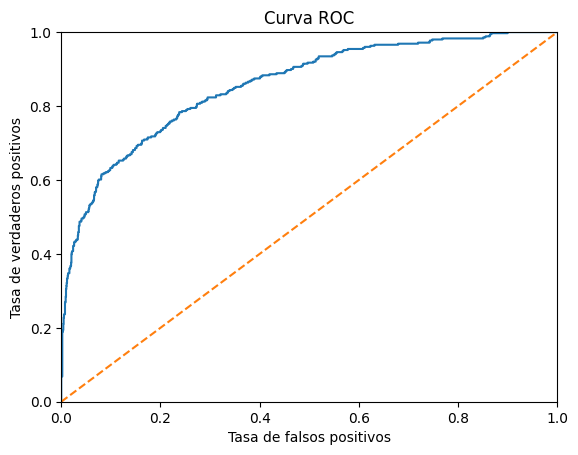

In [37]:
# Encontrando las variables de la curva ROC.
fpr, tpr, thresholds = roc_curve(data_target_ordinal_test, probabilities_one_test)

# Generando la figura.
plt.figure()

plt.plot(fpr, tpr)

# Curva ROC para modelo aleatorio (parece una línea recta).
plt.plot([0, 1], [0, 1], linestyle='--')

# Ajustes para la gráfica.
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")

plt.show()

In [38]:
# Calculando el área bajo la curva de la gráfica.
auc_roc = roc_auc_score(data_target_ordinal_test, probabilities_one_test)
print(auc_roc)

0.8562874077179254


El valor del área bajo la curva ROC es de 0.86, por lo que no ha cambiado; mantenemos los resultados de estas métricas.

## Conclusiones <a id="end"></a>

- El modelo de bosque aleatorio de decisiones mostró los mejores resultados comparándolo con un modelo de regresión logística.

- Al realizar ajustes en el umbral de clasificación para balancear la clase objetivo y realizar escalado de sus características numéricas junto con codificación ordinal de las características categóricas, logramos preparar los datos para que ingresaran mejor al modelo de bosque aleatorio.

- Explorando con los hiperparámetros del modelo logramos determinar también que el número de estimadores que regreso mejores resultados en el conjunto de prueba fue  de 16, la longitud de los árboles fue de 9 y el umbral de clasificación de 0.32, esto nos permitió obtener una métrica de F1 de 0.63 aproximadamente confirmando la eficiencia junto con el área bajo la curva ROC que nos determinó un modelo más confiable que la predicción aleatoria siendo el resultado 0.86.

- Como conclusión final, el modelo cumple con la condición de superar el valor F1 de 0.59, por lo que podemos utilizarlo para determinar a los clientes que tienen una alta probabilidad de abandonar la compañía.